In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from adaptive_hci.datasets import OmniglotGridDataset, get_raw_omniglot_dataset
from autowriter.plotting import plot_motor_to_image, plot_encoded_moves
from autowriter.mingpt.model import GPT
from configs import AutoWriterConfig

/home/kilian/miniconda3/envs/adaptive_hci/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_type" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
plt.set_cmap('cividis')
sns.set_theme()

<Figure size 640x480 with 0 Axes>

In [3]:
config = AutoWriterConfig()

train_dataset = OmniglotGridDataset(('.'+config.omniglot_dir),
                                    context_len=config.context_len,
                                    char_idxs=config.character_idxs)

model_config = GPT.get_default_config()
model_config.model_type = config.model_type
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

model_filename = '../models/draw_gpt_state_dict_o_l.pt'
state_dict = torch.load(model_filename)
model.load_state_dict(state_dict)
model.eval()
print('loaded')

number of parameters: 2.69M
loaded


In [3]:
img_dir = Path('../datasets/omniglot/python/images_background/Latin/')
stroke_dir = Path('../datasets/omniglot/python/strokes_background/Latin/')

raw_omniglot = get_raw_omniglot_dataset(stroke_dir, img_dir)
n_characters = len([x for x in img_dir.glob('*')])

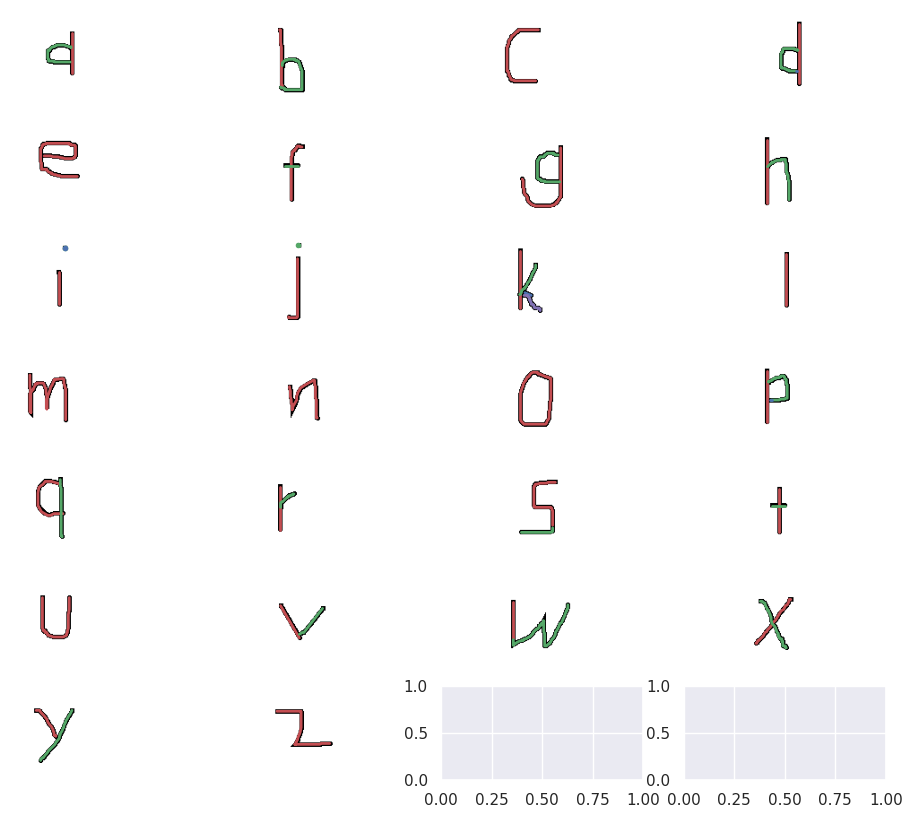

In [8]:
n_cols = 4
n_rows = int(np.ceil(n_characters / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))
for char_idx in range(n_characters):
    row_idx = char_idx // n_cols
    col_idx = char_idx % n_cols
    ax = axs[row_idx, col_idx]
    plot_motor_to_image(raw_omniglot[char_idx]['img'][0], raw_omniglot[char_idx]['motor'][0], ax, lw=2)

In [78]:
# Move indices:
# 0: left, 1: down, 2: right, 3: up

Text(0.5, 0.98, 'Training data')

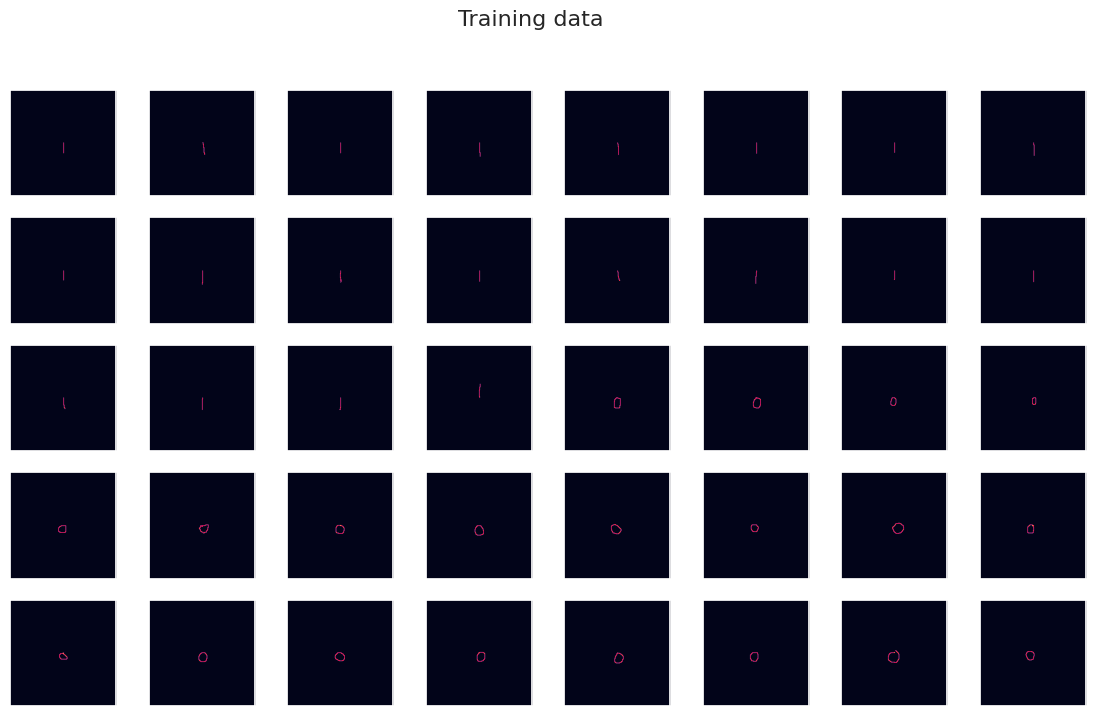

In [21]:
n_cols = 8
n_rows = int(np.ceil(len(train_dataset.data) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,8))
for i, stroke in enumerate(train_dataset.data):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]
    plot_encoded_moves(stroke, canvas_size=250, ax=ax)

fig.suptitle('Training data', fontsize=16)

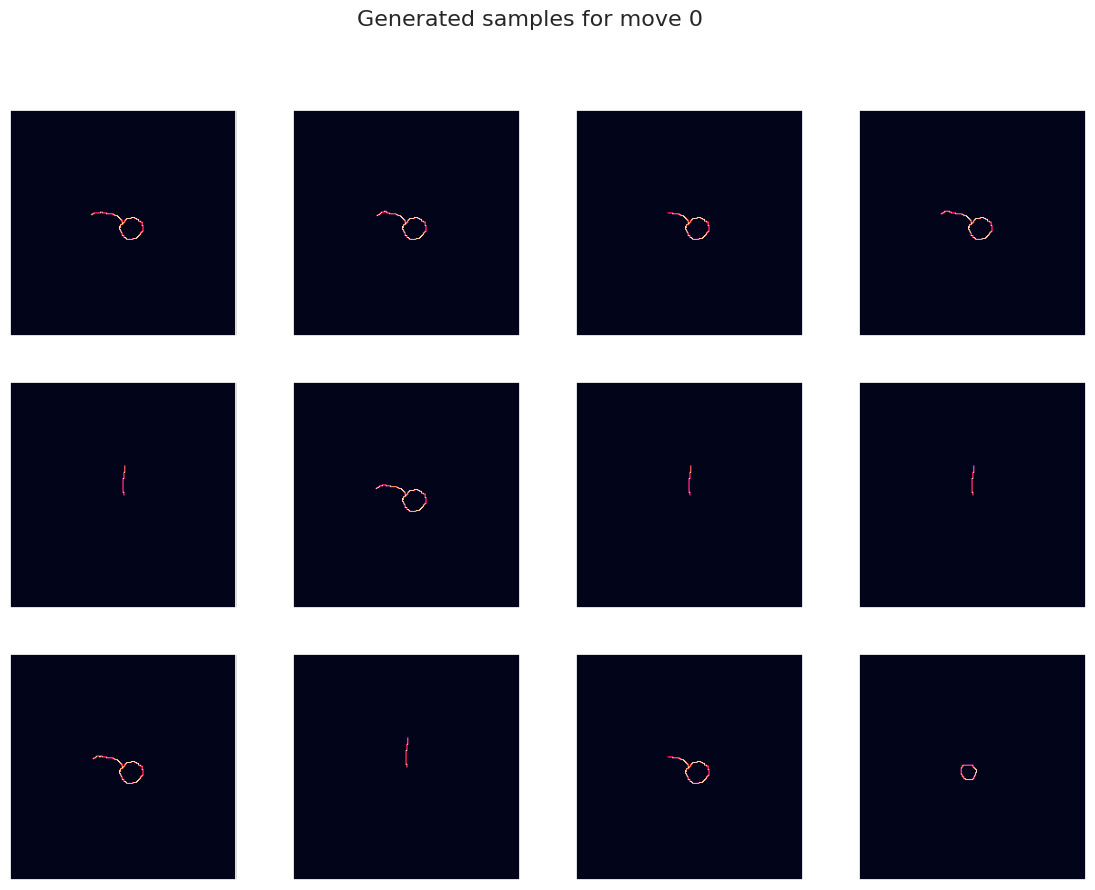

In [23]:
n_samples = 12
start_tokens = torch.tensor([0], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 0', fontsize=16)
plt.show()

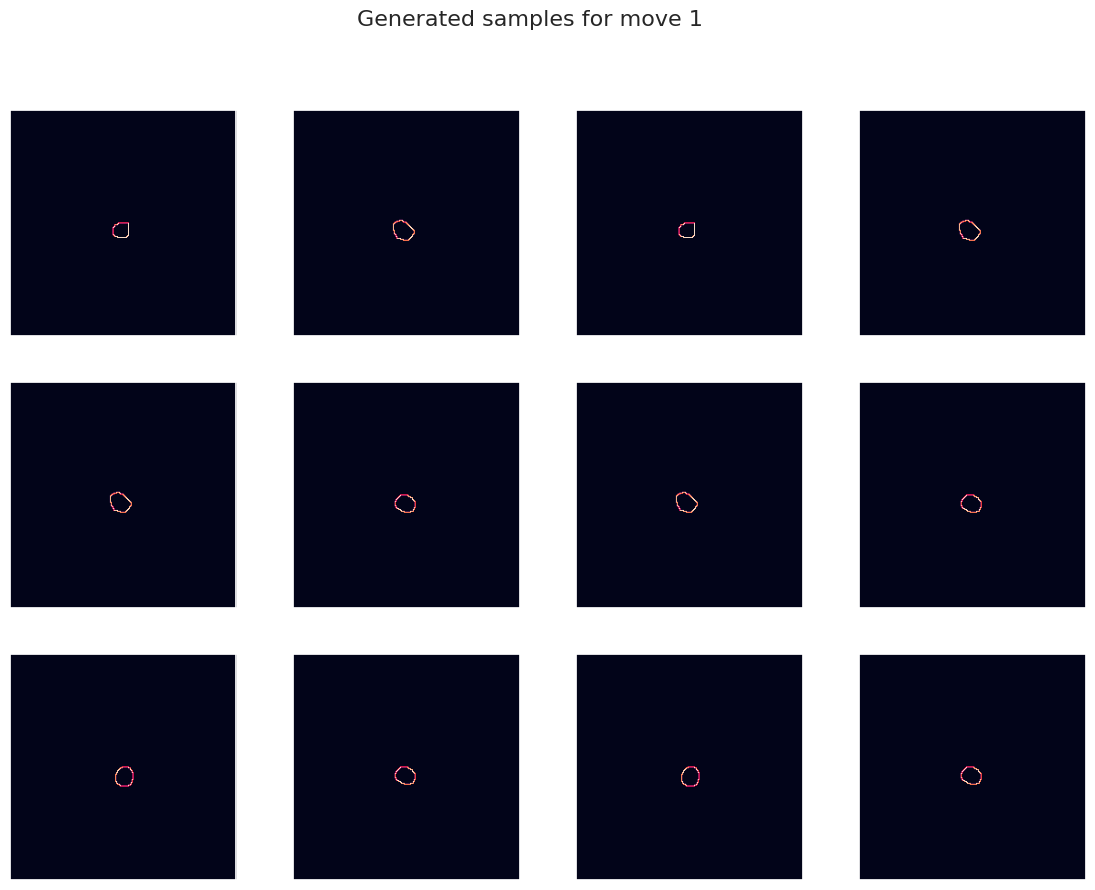

In [24]:
n_samples = 12
start_tokens = torch.tensor([1], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 1', fontsize=16)
plt.show()

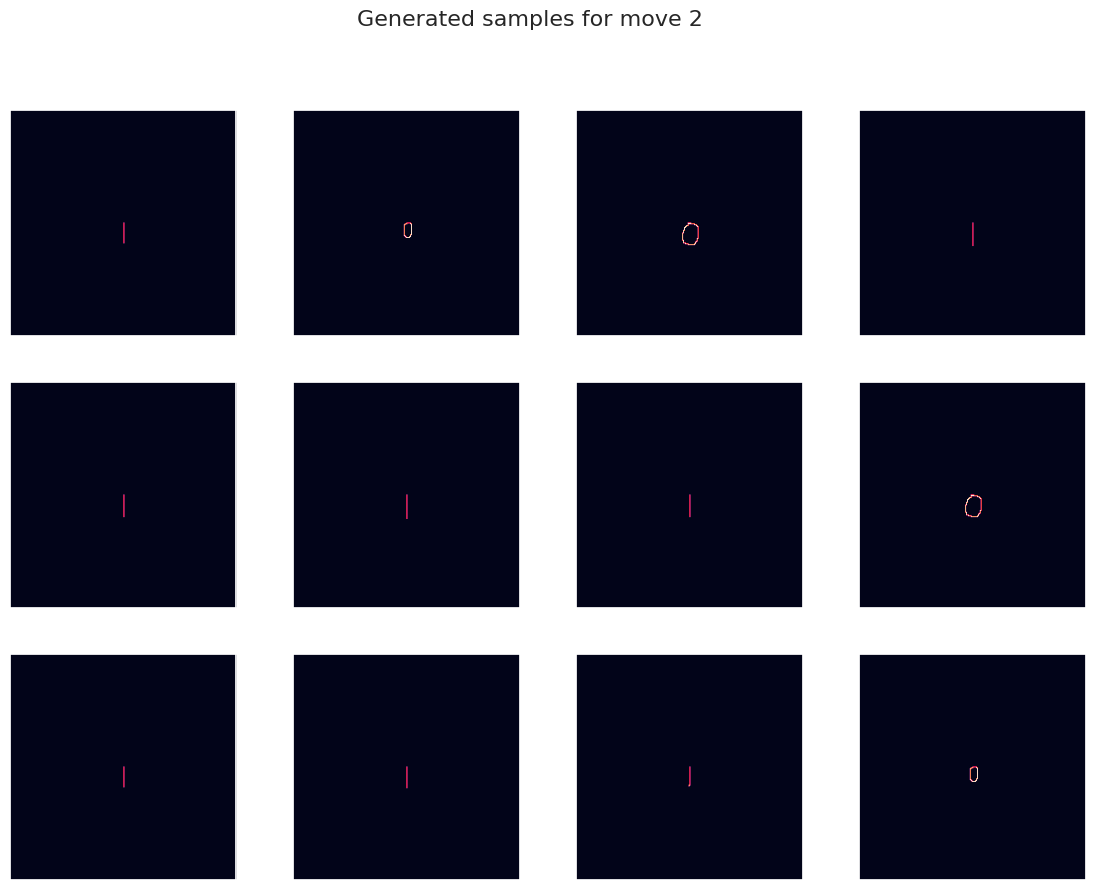

In [25]:
n_samples = 12
start_tokens = torch.tensor([2], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 2', fontsize=16)
plt.show()

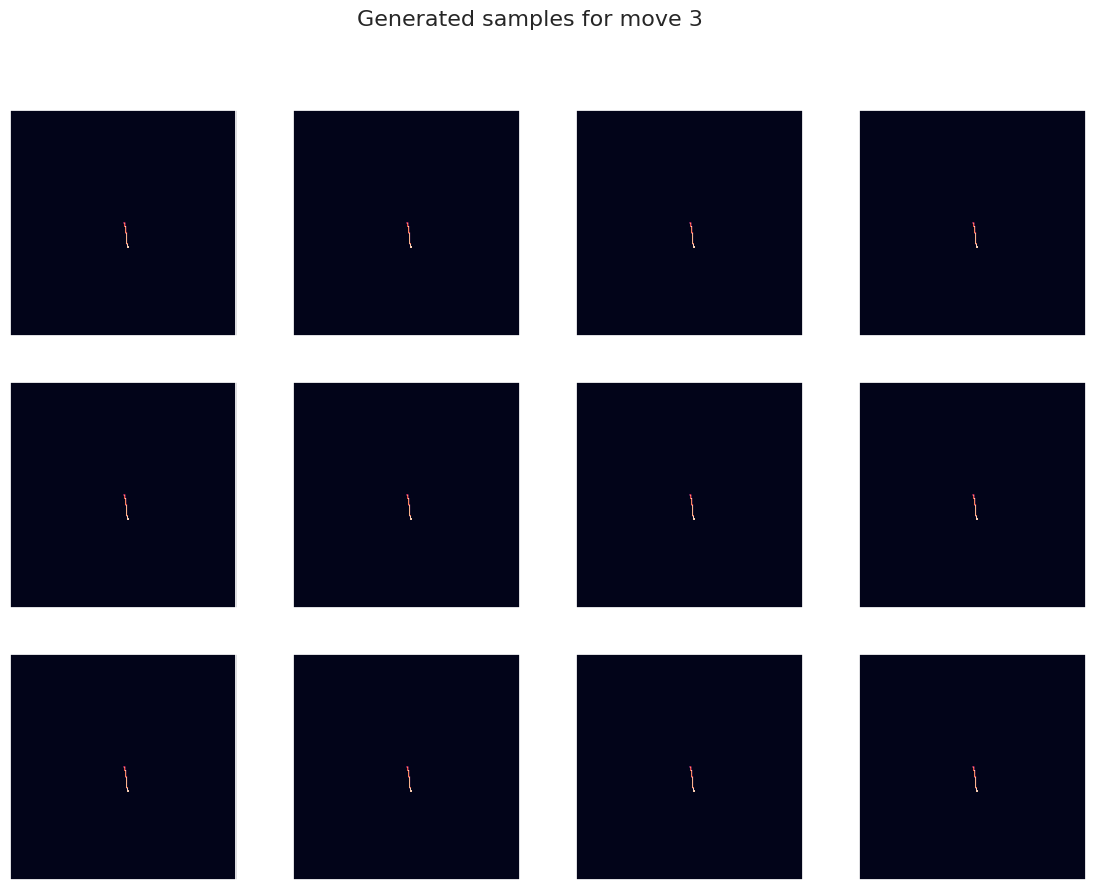

In [26]:
n_samples = 12
start_tokens = torch.tensor([3], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 3', fontsize=16)
plt.show()